In [5]:
import sys
base_dir = "D:/Thesis/Cobra/cobra/"
if base_dir not in sys.path:
    sys.path.append(base_dir)
from os.path import join
import pandas as pd
import seaborn as sns
from utilities import basic, utils, mri_stats, stats
from stats_tools import vis as svis
import numpy as np
import seaborn as sns
from access_sif_data import load_data_tools as ld
import matplotlib.pyplot as plt
from datetime import datetime as dt
%matplotlib inline
plt.rcParams["figure.dpi"] = 40
plt.style.use('ggplot')
import importlib
importlib.reload(utils)

<module 'utilities.utils' from 'D:/Thesis/Cobra/cobra\\utilities\\utils.py'>

In [10]:
fig_dir = join(base_dir, 'figs')
table_dir = join(base_dir, 'data/tables')
dfc = utils.load_scan_csv(join(table_dir, 'neg_pos_clean.csv'))

C:\Users\klein\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
df_volume_dir = pd.read_csv(join(table_dir, 'series_directories.csv'))
volume_dir_dic = pd.Series(
    df_volume_dir.Directory.values, index=df_volume_dir.SeriesInstanceUID)\
        .to_dict()

In [60]:
df_3d = dfc[dfc.MRAcquisitionType=='3D']
df_2d = dfc[dfc.MRAcquisitionType=='2D']
df_3d[['SeriesDescription', 'PatientID', 'SeriesInstanceUID']].to_csv(join(base_dir,'data','temp','3d.csv'), index=False)
from scipy import stats
x = df_3d.NumberOfSlices
df_3d_rm_outliers = df_3d[x.between(x.quantile(.5), x.quantile(.95))]
nos_3d_min = df_3d_rm_outliers.NumberOfSlices.min()

In [79]:
volume_dir_dic['2c2cbcc61ae0be8bdb0621e0843de65e']

'2019_10\\a3dcdbc4087d9ad6502e9a419e60ff15\\269680302796ca6b6ae1887e051c5ef2\\MR\\2c2cbcc61ae0be8bdb0621e0843de65e'

In [80]:
df_2d[df_2d.NumberOfSlices>80]

,SeriesInstanceUID,StudyInstanceUID,PatientID,AngioFlag,AcquisitionMatrix,AcquisitionContrast,AcquisitionDuration,dBdt,EchoTime,EchoTrainLength,...,SecondEcho,VariableFlipAngleFlag,DateTime,Sequence,TrueSequenceType,Positive,days_since_test,RowSpacing,ColumnSpacing,NumberOfSlices
7431,fcd139e7d79ac53777bbf883c72ba469,62392ba3d5356d1dbf80195500652167,70d5eeed0e1bf373e2e7f1e7d572854d,N,[0.0],NaN,NaN,0.000000,77.000,16.0,...,NaN,N,2019-01-22 11:08:48,flair,1,0,NaN,0.449219,0.449219,94.0
13513,0e01a6cee19ea467f85fbc3c51a77282,c11cab96f55f349a7971a9cbd4f45a23,caa39bbaeb2b6ffec6be850719cf0812,NaN,[0.0],NaN,283.205536,51.188015,7.973,8.0,...,NaN,NaN,2019-01-07 09:10:51,t1,1,0,NaN,0.575000,0.575000,100.0
13516,34a71fff3afc757e53ea962ec7fe9286,c11cab96f55f349a7971a9cbd4f45a23,caa39bbaeb2b6ffec6be850719cf0812,NaN,[0.0],NaN,323.663483,51.188015,7.973,8.0,...,NaN,NaN,2019-01-07 08:43:52,t1,1,0,NaN,0.575000,0.575000,120.0
18287,344a3a56e4105a53161d6fc227d2db8e,68a600565110271d925b7f6572489fae,1d688cfeb27dd49bdd64016efbee0c3c,NaN,[0.0],NaN,165.850342,46.461868,7.833,8.0,...,NaN,NaN,2019-10-15 10:48:55,t1,1,0,NaN,0.575000,0.575000,100.0
24806,2c2cbcc61ae0be8bdb0621e0843de65e,269680302796ca6b6ae1887e051c5ef2,a3dcdbc4087d9ad6502e9a419e60ff15,NaN,[288.0],NaN,194.006683,45.761471,7.363,8.0,...,NaN,NaN,2019-10-10 12:35:48,t1,1,0,NaN,0.595238,0.595238,91.0
153360,8b4afb39f0123ee7aae47a3775778eb5,1caa920ab7af7122c90b07f6ab13ef5e,caa39bbaeb2b6ffec6be850719cf0812,NaN,[0.0],NaN,286.329132,53.002979,7.944,8.0,...,NaN,NaN,2019-08-07 12:20:58,t1,1,0,NaN,0.575000,0.575000,98.0
153362,f5803cc055a0e942bf6d9965888e11b9,1caa920ab7af7122c90b07f6ab13ef5e,caa39bbaeb2b6ffec6be850719cf0812,NaN,[0.0],NaN,185.853638,51.752254,7.915,8.0,...,NaN,NaN,2019-08-07 12:17:16,t1,1,0,NaN,0.575000,0.575000,98.0


(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

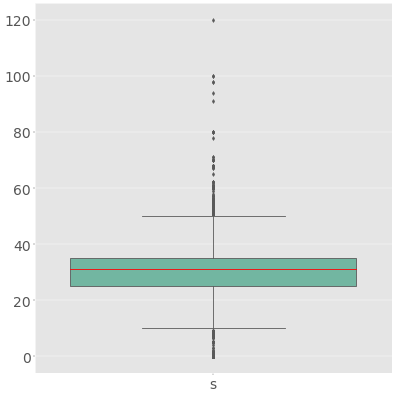

In [64]:
svis.create_boxplot(np.array(df_2d.NumberOfSlices), data_labels=['s'])

In [14]:
# Lists of relevant patients
ls_t1_pp = np.loadtxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_pre_post.txt", dtype=str)
ls_t1_post = np.loadtxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_post.txt", dtype=str)
#ls_t1_pos = np.loadtxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_pos.txt", dtype=str)
ls_t1_neg = np.loadtxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_neg.txt", dtype=str)
ls_t1_ppp = list(set(ls_t1_pp).union(set(ls_t1_post)))

In [26]:
df_t1_all = dfc[dfc.Sequence=='t1']
df_pp = dfc[(dfc.PatientID.isin(ls_t1_pp)) & (dfc.Sequence=='t1')]
df_post = dfc[(dfc.PatientID.isin(ls_t1_post)) & (dfc.Sequence=='t1')]

# Merge number of slices df with dfc and save

In [16]:
#present_ids = dfc[~dfc.NumberOfSlices.isna()].SeriesInstanceUID.unique()
#df_flair_missing = df_flair_all[~df_flair_all.SeriesInstanceUID.isin(present_ids)]

In [17]:
#utils.save_nscans_to_txt(df_flair_missing, 
#        f"{base_dir}/data/temp/flair_n_slices.txt", 'Y:', 'G:\\')

In [18]:
#df_flair_nos = pd.read_csv(f"{base_dir}/data/temp/flair_n_slices.txt", header=None, 
#    names=['SeriesInstanceUID','NumberOfSlices'])

In [19]:
#df_all = pd.read_csv(join(table_dir, 't1','all.csv'), index_col=0)
#dfc = pd.merge(dfc, df_all[['SeriesInstanceUID', 'NumberOfSlices']], on='SeriesInstanceUID', how='left')
#dfc = dfc.rename(columns={'xPixelSpacing':'RowSpacing','yPixelSpacing':'ColumnSpacing'})
#dfc.loc[dfc.NumberOfSlices.isna(), 'NumberOfSlices'] = dfc.merge(
#    df_flair_nos, how='left', on='SeriesInstanceUID')['NumberOfSlices_y']
#dfc.to_csv(f"{table_dir}/neg_pos_clean.csv", index=False, header=True)

# Create Box plots

## FLAIR

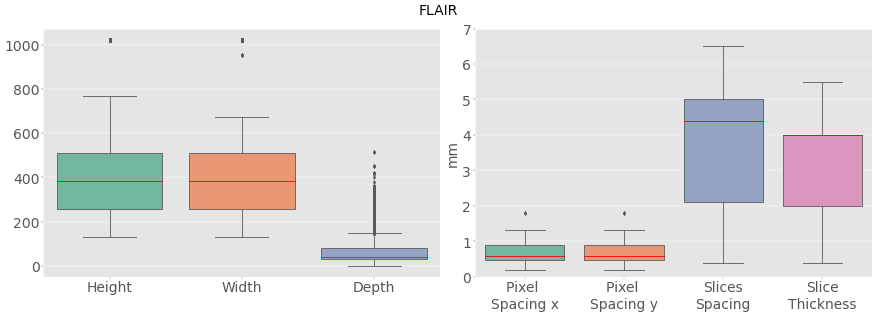

In [27]:
fig, ax = plt.subplots(1,2, figsize=(22,8))
df_flair_all = dfc[dfc.Sequence=='flair']
fig, _ = svis.create_boxplot(df_flair_all[['Rows', 'Columns', 'NumberOfSlices', ]], 
    data_labels=["Height", "Width", "Depth", ], 
    kwargs={'xlabel':'',},
    fig=fig, ax=ax[0])
svis.create_boxplot(df_flair_all[['RowSpacing', 'ColumnSpacing', 'SpacingBetweenSlices','SliceThickness' ]], 
    data_labels=["Pixel \nSpacing x", "Pixel \nSpacing y", 
                "Slices\nSpacing","Slice\nThickness" ], 
    kwargs={'xlabel':'','ylabel':'mm', 'yrange':(0,7)},
    fig=fig, ax=ax[1])
fig.suptitle("FLAIR", fontsize=25)
fig.tight_layout()
fig.savefig(join(fig_dir, 'flair', 'dimension_box_plot_flair_all.png'))

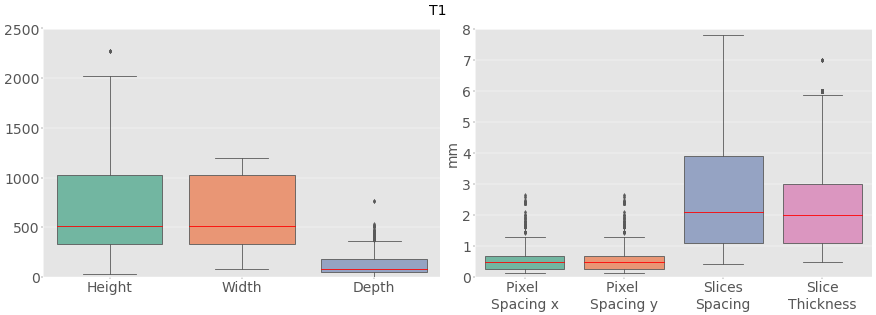

In [28]:
fig, ax = plt.subplots(1,2, figsize=(22,8))
fig, _ = svis.create_boxplot(df_t1_all[['Rows', 'Columns', 'NumberOfSlices', ]], 
    data_labels=["Height", "Width", "Depth", ], 
    kwargs={'xlabel':'','yrange':(0,2500), 'ylabel_fs':50,},
    fig=fig, ax=ax[0])
svis.create_boxplot(df_t1_all[['RowSpacing', 'ColumnSpacing', 'SpacingBetweenSlices','SliceThickness' ]], 
    data_labels=["Pixel \nSpacing x", "Pixel \nSpacing y", 
                "Slices\nSpacing","Slice\nThickness" ], 
    kwargs={'xlabel':'','ylabel':'mm', 'yrange':(0,8)},
    fig=fig, ax=ax[1])
fig.suptitle("T1", fontsize=25)
fig.tight_layout()
fig.savefig(join(fig_dir, 't1', 'dimension_box_plot_t1all.png'))

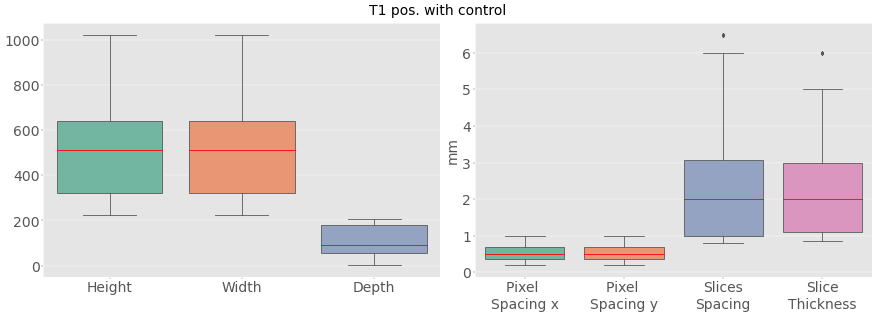

In [30]:
fig, ax = plt.subplots(1,2, figsize=(22,8))
fig, _ = svis.create_boxplot(df_pp[['Rows', 'Columns', 'NumberOfSlices', ]], 
    data_labels=["Height", "Width", "Depth", ], 
    kwargs={'xlabel':'','y_range':(0,400)},
    fig=fig, ax=ax[0])
svis.create_boxplot(df_pp[['RowSpacing', 'ColumnSpacing', 'SpacingBetweenSlices','SliceThickness' ]], 
    data_labels=["Pixel \nSpacing x", "Pixel \nSpacing y",
                 "Slices\nSpacing","Slice\nThickness" ], 
    kwargs={'xlabel':'','ylabel':'mm'},
    fig=fig, ax=ax[1])
fig.suptitle("T1 pos. with control", fontsize=25)
fig.tight_layout()
fig.savefig(join(fig_dir, 't1', 'dimension_box_plot_t1pp.png'))

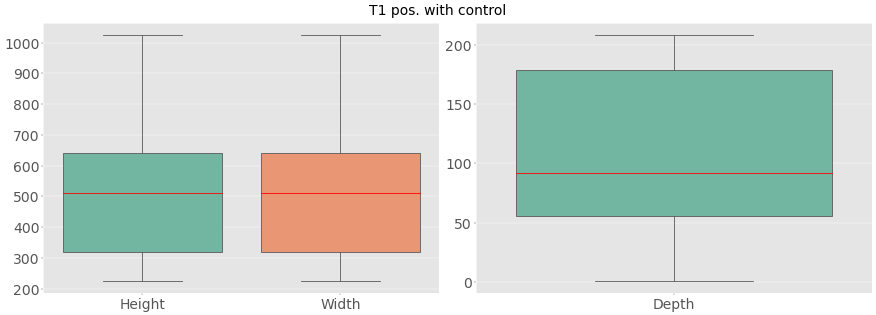

In [33]:
fig, ax = plt.subplots(1,2, figsize=(22,8))
fig, _ = svis.create_boxplot(df_pp[['Rows', 'Columns',]], 
    data_labels=["Height", "Width", ], 
    kwargs={'xlabel':'',},
    fig=fig, ax=ax[0])
svis.create_boxplot(df_pp[['NumberOfSlices', ]], 
    data_labels=["Depth" ], 
    kwargs={'xlabel':'',},
    fig=fig, ax=ax[1])
fig.suptitle("T1 pos. with control", fontsize=25)
fig.tight_layout()
fig.savefig(join(fig_dir, 't1', 'dimension_box_plot_t1pp_3d.png'))

## Number of patients with right slice distances (3d volumes)

<AxesSubplot:>

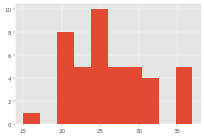

In [88]:
df_t1_pp_2d = df_t1_pp[df_t1_pp.MRAcquisitionType=='2D']

In [103]:
df_unknown_ssp =  df_t1_pp[df_t1_pp.SpacingBetweenSlices.isna()]
df_t1_pp_3d_temp = df_t1_pp[(df_t1_pp.MRAcquisitionType=='3D') | (df_t1_pp.NumberOfSlices>=50)]

### How many of those have now scans before and after

In [131]:
df_pos_3dt1 = dfc[(dfc.days_since_test>=-3) & (dfc.Sequence=='t1') & (dfc.MRAcquisitionType=='3D')]

In [137]:
df_pos_3dt1.sort_values(
    by=['NumberOfSlices','PatientID','SeriesInstanceUID'])[
        ['NumberOfSlices','PatientID','SeriesInstanceUID']].to_csv(join(base_dir,'data','temp','pos_3dt1.csv'))

In [135]:
volume_dir_dic['0c9e5d439bd82096a07cf44cf7a0cf4a'] 

'positive\\0272922a8e1331758757be7a7460571f\\a213ff3897205841639b4717961d1d96\\MR\\0c9e5d439bd82096a07cf44cf7a0cf4a'

In [129]:
df_pos_3dt1.PatientID.nunique()

165

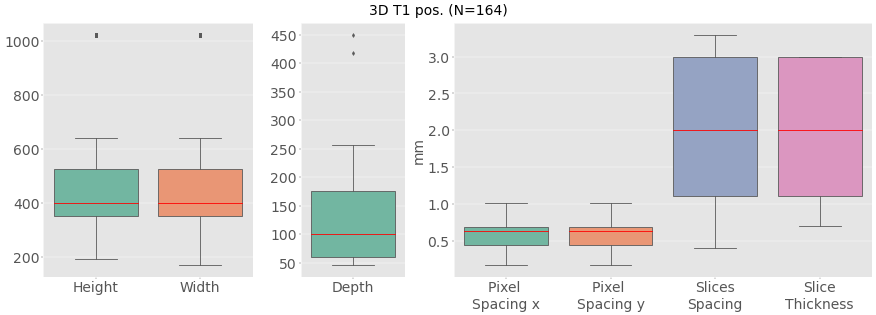

In [139]:
fig, ax = plt.subplots(1,3, figsize=(22,8),gridspec_kw={'width_ratios': [2, 1,4]})
df_pos_3dt1_m = df_pos_3dt1[~(df_pos_3dt1.NumberOfSlices==0)]
fig, _ = svis.create_boxplot(df_pos_3dt1_m[['Rows', 'Columns',]], 
    data_labels=["Height", "Width", ], 
    kwargs={'xlabel':'',},
    fig=fig, ax=ax[0])
svis.create_boxplot(df_pos_3dt1_m[['NumberOfSlices', ]], 
    data_labels=["Depth", ], 
    kwargs={'xlabel':'',},
    fig=fig, ax=ax[1])
svis.create_boxplot(df_pos_3dt1_m[['RowSpacing', 'ColumnSpacing', 'SpacingBetweenSlices','SliceThickness' ]], 
    data_labels=["Pixel \nSpacing x", "Pixel \nSpacing y",
                 "Slices\nSpacing","Slice\nThickness" ], 
    kwargs={'xlabel':'','ylabel':'mm'},
    fig=fig, ax=ax[2])
fig.suptitle("3D T1 pos. (N=164)", fontsize=25)
fig.tight_layout()
fig.savefig(join(fig_dir, 't1', 'box_plot_3dt1_pos.png'))

In [104]:
ls_pat_pre = df_t1_pp_3d_temp[df_t1_pp_3d_temp.days_since_test<=-30].PatientID.unique()
print(len(ls_pat_pre))
df_t1_pre_3d = df_t1_pp_3d_temp[df_t1_pp_3d_temp.PatientID.isin(ls_pat_pre)]
df_t1_pp_3d = df_t1_pre_3d[df_t1_pre_3d.days_since_test>=-3]
print(df_t1_pp_3d.PatientID.nunique())

28
21


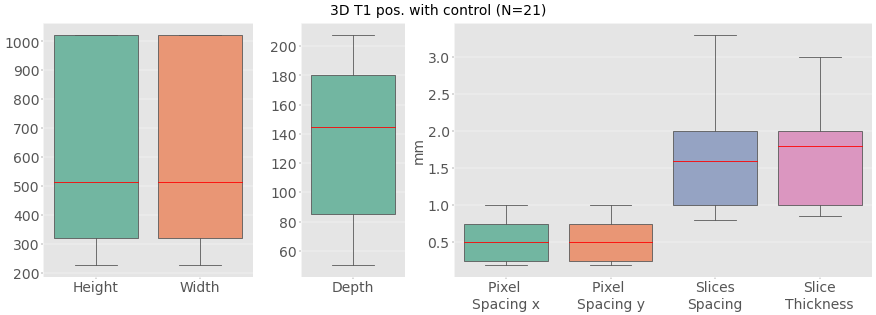

In [125]:
fig, ax = plt.subplots(1,3, figsize=(22,8),gridspec_kw={'width_ratios': [2, 1,4]})
fig, _ = svis.create_boxplot(df_t1_pp_3d[['Rows', 'Columns',]], 
    data_labels=["Height", "Width", ], 
    kwargs={'xlabel':'',},
    fig=fig, ax=ax[0])
svis.create_boxplot(df_t1_pp_3d[['NumberOfSlices', ]], 
    data_labels=["Depth", ], 
    kwargs={'xlabel':'',},
    fig=fig, ax=ax[1])
svis.create_boxplot(df_t1_pp_3d[['RowSpacing', 'ColumnSpacing', 'SpacingBetweenSlices','SliceThickness' ]], 
    data_labels=["Pixel \nSpacing x", "Pixel \nSpacing y",
                 "Slices\nSpacing","Slice\nThickness" ], 
    kwargs={'xlabel':'','ylabel':'mm'},
    fig=fig, ax=ax[2])
fig.suptitle("3D T1 pos. with control (N=21)", fontsize=25)
fig.tight_layout()
fig.savefig(join(fig_dir, 't1', 'dimension_box_plot_3dt1pp.png'))

In [46]:
volume_dir_dic['471e2785ea4f2fe0904310ab16a0cc85']

'positive\\2b4e626448a4fe7dc2d75cc496c916c7\\f7bd8b6f492506a5dd9dc1261e6a08aa\\MR\\471e2785ea4f2fe0904310ab16a0cc85'

In [45]:
df_unknown_ssp = df_unknown_ssp[df_unknown_ssp.NumberOfSlices>=nos_3d_min]
df_unknown_ssp_2d = df_unknown_ssp[~(df_unknown_ssp.SeriesDescription.str.contains('3D') | df_unknown_ssp.SeriesDescription.str.contains('3d'))]
df_unknown_ssp_2d[['PatientID','SeriesInstanceUID']].sort_values(
    by=['PatientID','SeriesInstanceUID']).to_csv(join(base_dir,'data','temp','t1_unknown_sd.csv'))

# Identify tumor patients

In [7]:
tumor_patient_tag = ['82f44e', '06c4453', '244a7d', '85b117f',
                        ]
tumor_patient_list = []
for tag in tumor_patient_tag:
    tumor_patient_list.append(
        dfc[dfc.PatientID.str.startswith(tag)].PatientID.unique()[0])

In [9]:
df_t1_pc = dfc[dfc.PatientID.isin(tumor_patient_list)]

In [13]:
df_t1_pc[df_t1_pc.Sequence=='t1'][['SeriesInstanceUID', 'PatientID']].to_csv(
    'D:\Thesis\Cobra\cobra\\figs\sp\T1\cancer.csv')

# Get list of t1 pos/control scans

In [189]:
arr_t1_neg = dfc[(dfc.Sequence=='t1') & (dfc.Positive==0)].PatientID.unique()
np.savetxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_neg.txt", arr_t1_neg,
        delimiter=" ", fmt="%s")

In [190]:
arr_t1_all = dfc[dfc.Sequence=='t1'].PatientID.unique()
np.savetxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_all.txt", arr_t1_all,
        delimiter=" ", fmt="%s")

In [10]:
ls_t1_pos = dfc[(dfc.Sequence=='t1') & (dfc.Positive==1)].PatientID.unique()
ls_t1_pos_rest = list((set(ls_t1_pos)-set(ls_t1_post))-set(ls_t1_pp))
np.savetxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_pos_rest.txt", np.array(ls_t1_pos_rest),
    delimiter=" ", fmt="%s")

In [16]:
arr_t1_pos_rest_suid = np.array(dfc[(dfc.Sequence=='t1') & (dfc.PatientID.isin(ls_t1_pos_rest))].SeriesInstanceUID.unique())
np.savetxt("D:\Thesis\Cobra\cobra\data\patient_groups\\t1_pos_rest_suid.txt", arr_t1_pos_rest_suid,
    delimiter=" ", fmt="%s")